In [1]:
import functions as f
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import s3fs
import cftime
import intake
import numpy as np
from joblib import Parallel, delayed
from pyproj import Transformer
from datetime import datetime
from scipy import stats
from dask.diagnostics import ProgressBar
import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.widgets import Slider, Button 
from ipywidgets import interactive
import time
import os
%load_ext autoreload
%autoreload 2
%matplotlib inline
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))

# Model Reliability of Arctic Ocean Salinity

*Report for the course GEO4990 The Earth System at UiO, eScience Course Tjarnmö 2022*

*Name:* Mateusz Matuszak

*Email:* mateusma@mail.uio.no

*Date:* 17.11.2022

*Assistant:* Antoine Haddon

# Abstract

This project aims to investigate salinity in the Arctic. Two different Arctic regions have been chosen for this study, the Greenland Sea and the Laptev Sea. Satellite observations of sea surface salinity is used to investigate the salinity at the ocean surface in both regions, while CTD measurements from ARGO floats have been used to investigate the salinity at depth at the Greenland Sea region, but not at the Laptev Sea region, as there are noe ARGO floats here. There are few ocean observations in the Arctic due to the harsh environment, causing missing data in the observations. Therefore, numerical models are crucial for filling the gaps in the missing observations. We introduce two numerical models, the UKESM and CNRM, and validate their salinity predictions using the available salinity observations. We find evidence of seasonality of sea surface salinity being heavily influenced by sea ice extent, especially in the Greenland Sea region. This influence is not as apparent in the Laptev Sea region, however, this regions includes additional sources of freshwater input, such as river runoff. Both UKESM and CNRM seem to underestimate the sea surface salinity at the Greenaldn Sea region, and overestimate it at the Laptev Sea region, however, UKESM deviates less from observations than CNRM. Meanwhile, CNRM proves to produce salinity predictions at water column depth which are fairly close to CTD measurements, and although both models are better with depth than they are at the surface, CNRM deviates slightly less than UKESM when it comes to salinity in the vertical.



# Introduction

The Arctic has a greater temperature increase than other parts of the world because of arctic amplification. This has a direct influence on the sea ice extent, which has decayed rapidly in the last 30 years. This, in turn, inpacts the freshwater flux into the ocean sea surface, freshening the upper part of the water column and making it more stable, which may be linked to changes in the thermohaline circulation, and can therefore impact not only the circulation in the Arctic, but also around the whole globe [Manabe and Stouffer, 1995].

There exists numerous earth system models which include both the salinity at the ocean surface, as well as the vertical structure of the ocean. However, such models often parameterize the salinity in the ocean. Therefore, good in situ measurements are needed to tune the parametrizations of the models to reflect the real world better. This, in turn, is problematic, as in situ measurements of the ocean are very scarce due to the difficult ocean conditions, making research voyages expensive. [Mart ́ınez et al., 2020]. There are especially few ocean measurements in the polar regions, as these regions exhibit even harder conditions than the rest of the world oceans, due to among other things rough currents, sea ice and cold temperatures. 

Good numerical models are therefore crucial for understanding ocean processes the world oceans, especially in the polar regions. This study will focus on the ocean salinity in the Arctic, and will compare observational data on the sea surface salinity from the BEC Arctic+ satellite product and salinity data from ARGO floats in the Arctic to two earth system models, the UKESM and CNRM to see how well these two models perform at parametrizing the ocean salinity. 

This paper will focus on sea ice as a main contributor to the freshwater fluxes in and out of the ocean, however, we keep in mind that other factors, such as precipitation and river runoffs are important sources of freshwater in the ocean as well. 

## Sea Ice Effect on Sea Surface Salinity

Formation and decay of sea ice is a major driving factor for the sea surface salinity. Formation of sea ice requires the freezing of salty ocean water, however, the salt crystals will not be freezed with the water, but rather separated from the water during this process. The salt crystals will then try to mix with the remaining, unfreezed water, in turn making it even saltier, and lowering the temperature required for it to freeze. This very salty water is called brine, and can either be trapped in the sea ice, creating pockets in the sea ice with salty cold water which does not freeze because of the salt level, or it can escape from the ice and flow out into the ocean surface. Due to the high concentration of salt in the brine, it is heavier than regular ocean water at the surface, and will start sinking, disrupting the stability and stratification of the upper water column, leading to convective mixing. 

Decay of sea ice releases freshwater into the ocean. Freshwater is lighter than the salty ocean water, and will stay on top of the water column. This in turn stabilizes the water column, and prevents vertical mixing. Decay of sea ice is most prevelant during the melting season, but freshwater input into the ocean can come from other sources, such as river runoffs and precipitation, which stabilizes the water column.

Another way sea ice can affect the ocean is by covering it up, blocking out both sunlight and atmospheric forcing. This is not directly related to the salinity in the ocean, but is still important for the vertical circulation. This controlls the windstress input into the ocean, as well as heat input. Additionally, when sea ice floats in a different direction of the ocean currents, for example due to the wind stress in the atmospheric boundary layer, which in turn will stirr the water column [Thomas, 2017]. 

In terms of sea ice, this paper will mostly focus on the freshwater input into the ocean as a result of sea ice decay.



# Data

## Satellite Observations of Salinity at the Sea Surface
The sea surface salinity (SSS) satellite observations are produced by Barcelona Expert Center (BEC) as a part of the Arctic+ salinity project. Measuring SSS using satellites has proved to be challenging, as the sensitivity of the brightness temperature to SSS is low, and the changes is SSS in the open ocean are small if river discharge is not considered. This means that the satellite accuracy has to be high to capture the regional changes in SSS. The Arctic+ project was launched as an initiative by the European Space Agency (ESA) to improve the existing Soil Moisture and Ocean Salinity (SMOS) satellite data. The methodology for how this has been improved is explained in [Mart ́ınez et al., 2022], and the product is an improved SSS observational system with a higher spatial resolution. 

The dataset contains a 9-day Arctic SSS product from satellite observations, placed in an EASE-Grid 2.0 North. It covers the whole Arctic region, from -180 to 180 longitude and 50 to 90 latitude, while the geospatial resolution is 25km. The dataset also contains data from January 2011 to December 2019. The dataset is freely accessible on https://bec.icm.csic.es/.

## Satellite Observations of Sea Ice Extent
The sea ice extent (SIE) sattelite observations are produced by the AMSR2 satellite at the University of Bremen. The data has a 6.25 grid resolution, and uses the ARTIST sea ice algorithm. For more information on how the satellite works, please see [Spreen et al., 2008].

## CTD Measurements of Ocean Vertical Structure
The CTD measurements are provided by the ARGO program, which is an international program which aims to constantly measure the properties of ocean water, such as salinity and temperature, across the globe. To do this, the ARGO program has placed out around ~3800 automatic floats in the ocean (number of floats is increasing each year), which sink down to some ocean depth before floating up again, all while measuring different ocean paramters. After emerging, these floats send their data to some database and sink down again, which happens on average on a 10 day cycle [Argo, 2022].

Unfortunately, ARGO floats are not so common in the Arctic, as the harsh environment and sea ice prevents ruins the floats more often than not. There are for instance no ARGO floats in the Laptev Sea, which is one of the study regions in this paper, due to the region being completely covered by sea ice during large periods of the year. However, there are still some floats in the Greenland Sea region which will be used in this paper to study the vertical structure of the ocean at these location, which will also be used as a validation for the vertical structure of earth system models. The measurement data can be accessed from https://argo.ucsd.edu/data/.

I have chosen a single ARGO float for this study. This float has 65 profiles relatively close to one another in the Greenland Sea region, and approximately one profile every ten days from August 2016 to June 2018.

## Earth System Models
The models which will be considered in this paper are the UKESM (UKE Earth System Modelling Project), and the CNRM (Centre National de Recherches Meteorologiques), and both models are part of the CMIP6 project (Coupled Model Intercomparison Project), hosted by WCRP (The World Climate Research Programme). Both models are coupled ocean and atmosphere models.  

CNM has a spatial ocean resolution of 100km, and the historical experiment, which is the one that will be used, gives monthly data from 1850 to 2014. 



# Methods

All code used for data analysis are included in either this notebook, or in a separate "functions.py" file which should be in the same directory as this report. 

## Seasonality of Sea Surface Salinity
Because the sea ice extent (SIE) varies changes depending on the season, the SSS should in theory somewhat follow the sea ice variation, meaning that we should have a decrease in SSS during warmer seasons, when sea ice melts resulting in a freshwater input into the ocean, and vice versa. The seasonality of the SSS can be investigated by calculating the average SSS value of the specified region for each day. Then, one can group the averages by the day of the year, i.e. group all January 3rd for all years, group all february 23rd for all years, and so on, and find the average SSS value for the that specific day in any given year. 

By creating so called seasonality graphs, one can study how the SSS is expected to vary over the course of a year. This, in turn, makes it comparable to the seasonal SIE, to see if they are correlated or not. It is expected that sea ice and SSS will have a large correlation, however, there is also the possibility of other factors being at play. 

## Vertical Structure
ARGO floats measure the vertical structure of the water column at specific points in the ocean. However, due to ocean currents, these floats will advect somewhat in the horizontal direction as they descend through the water column, meaning that the vertical structure profile they produce is not only strictly from a vertical movement. Meanwhile, the vertical structure of the models are divided into grids, which do not advect horizontally, so that the vertical structure here will be strictly vertical. 

There is also the issue of the gridcells in the models. Each gridcell has homogeneous values, and each cell is quite large spatially (100km for CNRM). This means that it is near impossible to get the vertical structure from the models at the exact locations where the ARGO floats measured. To counteract these two issues, I will take the mean vertical structure of all the profiles for the chosen ARGO float in the Greenland Sea region. Then, I will select a region around these measured profiles from the model data, and calculate the mean vertical structure from the model outputs over this region and over time.

As there are no floats in the second region we will be looking at, the Laptev Sea, I decided that I will first compare the average vertical structure from the ARGO profiles to modelled vertical structure in the Greenland Sea, and then compare model outputs for the Laptev Sea without having observational profiles to compare to. 

## Model Comparison
The UKESM and CNRM both respectively include 16 and 11 model members which contain the ocean salinity variable. Each member calculates their respected variable value based on the implemented parametrization for that variable in their model, however, the way the members differ is in their initial conditions. Therefore, the members will yield somewhat different results. An idea would be to just pick out a member from both models at random, however, this approach might prove to be problematic, as the randomly selected member might have initial conditions which are not realistic. Instead, we will bring in all members in UKESM and CNRM which contain the ocean salinity variable, and avarage over them. 

Additionally, the gridcells in the models also vary with latitude, meaning that simply taking the average over the cells is not sufficient, as some cells are larger than others. Therefore, we have to do a weighted average based on the size of the cells. Fortunately, the models include a variable called *areacello*, which is the size of each gridcell and can be used to weight the average by the cell size. The weighted average can be calculated in the following matter:

$\text{weighted_mean} = \frac{1}{A} \sum_i \sum_j S_{i,j} \cdot a_{i,j}$

Where *A* is the sum of the size of all the cells in the selected region, $S_{i,j}$ is the salinity value at cell *i, j* and $a_{i,j}$ is the size of cell *i, j*, extracted from the *areacello* variable. As the gridcells in the observed satellite data are equal in size, a weighted average is not necessary there.


# Study area

In [2]:
path='escience2022/Antoine/ESA_SMOS_Arctic_Sea_Surface_Salinity/'
years = [2011,2012,2013,2014,2015,2016,2017,2018,2019]
sat_data = f.collect_satellite_data(years, path)

In [3]:
f.interactive_plot_whole_region(sat_data, title='Sea Surface Salinity Around The Polar Region')

interactive(children=(Dropdown(description='time', index=250, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1…

*Figure 1: Sea surface salinity observational data from BEC Arctic+ product for the whole Arctic region for 2011-09-09. Major rivers are also included in the figure. The figure includes an interactive slider which allows for day change, so that one can inspect the SSS at different days in 2011 (Jupyter Notebook only).*

In [4]:
SatRegion1 = f.slice_data(sat_data, '2009-01-01', '2022-02-01', -10, 10, 70, 85)
SatRegion2 = f.slice_data(sat_data, '2009-01-01', '2022-02-01', 100, 160, 70, 80)

In [5]:
f.interactive_plot(SatRegion1, SatRegion2)

interactive(children=(Dropdown(description='time', index=250, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1…

*Figure 2: Sea surface salinity observational data from BEC Arctic+ product for two defined regions at 2011-09-09, Greenland Sea (left) (-10 to 10 lon, 70 to 85 lat) and Laptev Sea (right) (100 to 160 lon, 70 to 80 lat). Rivers are included in the figure. An interactive slider allows to change the day in 2011 shown in the figure (Jupyter Notebook only).* 

Figure 1 shows the whole extent of the SSS from satellite observations during 2011-09-09. We imidietely notice that there is some missing data around the north pole, which is a direct result of the sea ice, which blocks the SSS satellite measurements of the ocean surface below the sea ice. However, the SIE is changing over the season due to ice melting during warmer seasons and water freezing during colder seasons, with SIE at a minimum sometime during the month of September. Figure 1 includes an interactive slider (available in Jupyter Notebook version), where one can select the day of the year in 2011 to see which regions have observations for that day. By using this slider and checking different days, we clearly see that the SIE changes over time. The changing SIE will directly result in more observational satellite data of SSS during warmer months and less during colder months. Additionally, we also see that the satellite filters out observations around the coasts. 

Figure 2 shows the two regions of focus for this paper during 2011-09-09. On the left we see an area in the Greenland Sea region, which I defined to be between -10 and 10 degrees longitude and 70 to 85 degrees latitude. On the right, we have the Laptev Sea, defined to be from 100 to 160 degrees longitude and 70 to 80 degrees latitude. As for figure 1, figure 2 includes an interactive slider available when viewing this paper in Jupyter Notebook. These two regions were selected because of large differences in their characteristics. 
* The Greenland Sea region has an average depth of ~1444m, where it goes down to around ~3000m in some areas [noa, 2021a], whille the Laptev Sea region is placed within a continental shelf. This results in the region having a rather deep maximum depth, at around ~3385m, but around 50% of the sea is less than 50m deep, giving the region a steep topography. The average depth in this Laptev Sea region is around ~578m [noa, 2021b].
* The Greenland Sea region is in open sea, meaning that it is not surrounded by land and while the SIE will cover up some parts of it during winter, large parts will still be open during ice extent maximum. In contrast, the Laptev Sea region is surrounded by land, and is almost completely covered by sea ice during the winter season. Due to this, there are few satellite observations during the winter seasons.
* Because the Laptev Sea is surrounded by land, there is also the possibility of the existance of rivers which run out into this region, which is a large source of freshwater input. Rivers are shown in figure 2, and we see that there are no rivers running out into the Greenland Sea.

As SSS is influenced by freshwater input, rivers, precipitation and sea ice melt play a great role in the changes in salinity. For this reason, the figures 1 and 2 include some of the major rivers in the area. As we clearly see, there are no rivers running off into the Greenland Sea region. This means that changes in salinity are mostly due to interaction with sea ice and precipitation in the Greenland Sea region, whereas rivers are included in the Laptev Sea region. From the right panel in figure 2 we see a larger salinity gradient in the region than in the Greenland Sea, with lower salinity in the sea surface closer to the coast where we have river runoff. 



# Results and discussion

## Seasonality

In [6]:
MeanSat = SatRegion1['sss'].groupby('time.dayofyear').mean(dim=['time', 'x', 'y']).compute()#.mean('x').mean('y').compute()
s = SatRegion1['sss'].mean(dim=['x','y']).compute().groupby('time.dayofyear')
StdSat = SatRegion1['sss'].groupby('time.dayofyear').std(dim=['time', 'x', 'y']).compute()

MeanSat2 = SatRegion2['sss'].groupby('time.dayofyear').mean(['time', 'x', 'y']).compute()
s2 = SatRegion2['sss'].mean(dim=['x', 'y']).compute().groupby('time.dayofyear')
StdSat2 = SatRegion2['sss'].groupby('time.dayofyear').std(dim=['time', 'x', 'y']).compute()

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


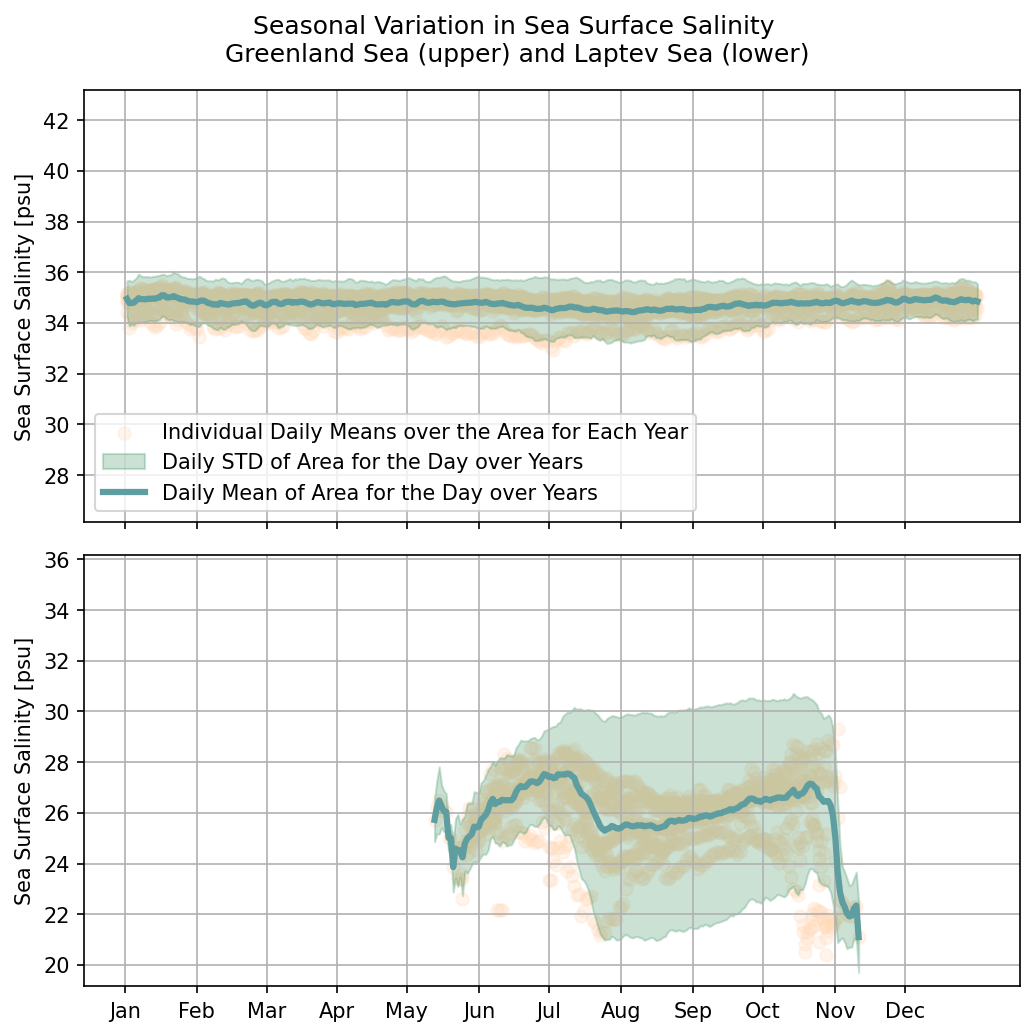

In [7]:
x = np.arange(1,367)

dic = { 0:'Jan', 31:'Feb', 61:'Mar', 91:'Apr', 121:'May', 152:'Jun', 182:'Jul', 213:'Aug', 244:'Sep', 274:'Oct', 305:'Nov', 335:'Dec'}
ticks = [0,31,61,91,121,152,182,213,244,274,305,335]
labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]

fig, ax = plt.subplots(2,figsize=(7,7), dpi=150, sharex=True)
for month in s.groups.keys():
    m = np.full(len(s[month]), month)
    sct = ax[0].scatter(m, s[month], color='peachpuff', alpha=0.25)


for month in s2.groups.keys():
    m = np.full(len(s2[month]), month)
    sct2 = ax[1].scatter(m, s2[month], color='peachpuff', alpha=0.25)

ax[0].fill_between(x, MeanSat-StdSat, MeanSat+StdSat, color='seagreen', alpha=0.25, label='Daily STD of Area for the Day over Years')
ax[1].fill_between(x, MeanSat2-StdSat2, MeanSat2+StdSat2, color='seagreen', alpha=0.25)
sct.set_label('Individual Daily Means over the Area for Each Year')

ax[0].plot(x, MeanSat, color='cadetblue', lw = 3, label='Daily Mean of Area for the Day over Years')
ax[1].plot(x, MeanSat2, color='cadetblue', lw = 3)

ax[0].set_xticks(ticks)
ax[0].set_xticklabels(labels)
ax[0].set_ylabel('Sea Surface Salinity [psu]')
ax[1].set_ylabel('Sea Surface Salinity [psu]')
ax[0].legend(loc='lower left')

plt.tight_layout()
ymin, ymax = ax[0].get_ylim()
ymin2, ymax2 = ax[1].get_ylim()
ax[0].set_ylim([ymin2+7, ymax+7])
ax[1].set_ylim([ymin2, ymax])
ax[0].grid()
ax[1].grid()
fig.suptitle('Seasonal Variation in Sea Surface Salinity \nGreenland Sea (upper) and Laptev Sea (lower)')
plt.tight_layout()
plt.show()

*Figure 3: The seasonality of the sea surface salinity in the Greenland Sea (upper) and Laptev Sea (lower) calculated by taking daily mean for each year over the whole satellite dataset, 2009-01 to 2019-12. The Turqoise line shows the average salinity value at the surface for the region, with the green filled out area around the line around the mean being the standard deviation. The orange dots are the daily mean of the region for each specific day*

Figure 3 shows the seasonal variation in SSS from the satellite observations for the two selected region, Greenland Sea (upper) and Laptev Sea (lower). The orange dots in the figure represent the daily average of the region for each specifc day in each specific year, whereas the thich turqoise line represents the average SSS value for the region over multiple years. Figure 3 also includes the standard deviation from the mean, represented with a green area around the average (turqoise line), to show the spread in the average values.

By first looking at the seasonality of the Greenland Sea in the upper panel of figure 3, we see that there is a small decrease in the average SSS starting from around the middle of June, where the SSS drops from approximately ~35 psu in the beginning of June to approximately ~34.5 psu in August. This decrease is rather small, and seems almost constant compared to the changes in the average SSS for the Laptev Sea, so this will be enlarged in the next section where we compare SIE to the SSS. However, this small decrease in SSS during the warmer months implies that the freshwater input into the ocean as a result of melting sea ice is in fact contributing to the decrease in SSS.

Now looking at the seasonality of SSS for the Laptev Sea in the lower panel of figure 3, the first thing we notice is that there is no data between the middle of November and the middle of June. This is a direct result of the region being covered by sea ice during this period, as can be seen if one would change the day in the interactive figure 2. As a matter of fact, in the beginning of June, the Laptev Sea region is still not really opened up, and the average might be heavily influenced by which part of the region opens up first. As we see in figure 2, there is a large SSS gradient between the coastal waters and the ocean some distance away from the coast. This means that if the coastal waters thaws first, the average SSS lean towards lower values, while if the waters some distance away from the coast thaws first, the average SSS will lean towards larger values. The same applies for the when the ocean freezes during the colder months. To counteract this, the beginning and the end of the period should not be considered. 

By looking through the different days in figure 2, we see that it is in fact the more open and saltier waters which thaw first in the Laptev Sea, and that the sweeter coastal waters thaw somewhere in the middle of July. This is reflected in the lower panel in figure 3, where we see that the average SSS for the region drops quickly during June. To emphesize, this does not necessarily mean that we have a sudden large freshwater input, but rather, that the sweeter region thaws and is then included when the average is calculated. 

Figure 2 also indicates that the fresher water in the Laptev Sea freezes first. This can be because the coastal waters are colder due to different factors, for example cold temperature flux from the land or warm temperature to the open waters due to some underlying ocean current. However, another explanation for this is that fresher waters freeze at a higher temperature than saline waters. This happens because salt molecules blocks the water molecules from grouping together, which in turn prevents the water from freezing. So water freezes at a lower temperature as the salinity increases *reference the book*. By assuming that the temperature is homogeneous over the whole region, which is not a fair assumption and should really be investigated, we can assume that the fresher water thaws later and freezes earlier than saline water simply because the temperature required for thawing and freezing fresher water is closer to 0 degrees Celcius compared to saline water. Note however, that when we are talking about fresher or sweeter waters, we are still talking about saline waters, just less saline waters in comparison to other regions. 

Going back to figure 3, another interesting part of the figure is that the standard deviation of the SSS is much larger for the Laptev Sea than for the Greenland Sea. This reflects the fact that there is a large variance in the SSS in the Laptev Sea, both spatially, as we have discussed, and temporally. The temporal variance is reflected by the large spread of the individual average SSS values, represented by the orange dots in the figure, where we see that the average SSS value for a given day of the month tend to differ by a large amount from the same days in different years. Figure 4 below shows a histogram of the distribution SSS distribution for the two regions. 

In [8]:
MeanSat.to_netcdf('SSSGL.nc')
MeanSat2.to_netcdf('SSSLS.nc')

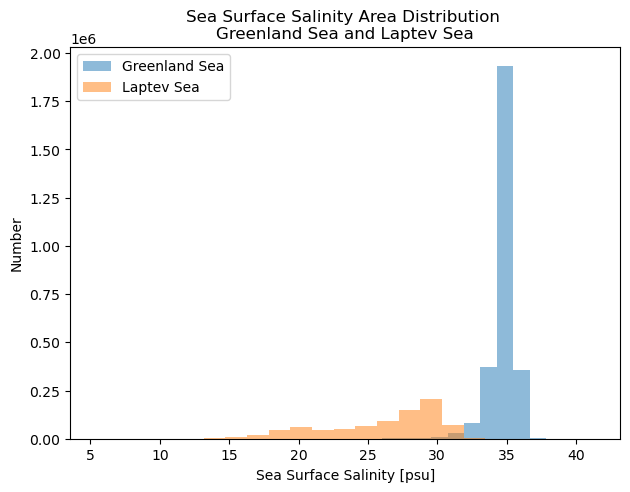

In [9]:
plt.hist(SatRegion1['sss'].values.ravel(), bins=20, alpha=0.5, label='Greenland Sea')
plt.hist(SatRegion2['sss'].values.ravel(), bins=20, alpha=0.5, label='Laptev Sea')
plt.xlabel('Sea Surface Salinity [psu]')
plt.ylabel('Number')
plt.legend(loc='upper left')
plt.tight_layout()
plt.title('Sea Surface Salinity Area Distribution \nGreenland Sea and Laptev Sea')
plt.show()

*Figure 4: Histogram of the sea surface salinity distribution over the whole satellite data period 2009-01 to 2019-12 over the Greenland Sea (blue) and Laptev Sea (orange).* 

Figure 4 shows the SSS distribution over the whole satellite data period over the Greenland Sea (blue) and Laptev Sea (orange). From the figure we see that the spread in SSS values is definitely larger for the Laptev Sea, which explains the standard deviation from figure 3. The Greenland Sea has most of its SSS values at around 35 psu, with some values deviation a little bit, and some extreme values going down to around 30 psu. Looking at figure 2 again, we see that this seems reasonable, as figure 2 shows a rather (but not perfectly) homogeneous salinity distribution over the Greenland Sea region.  

If one looks closely at the orange section of the histogram, the part representing the spread in the Laptev Sea, one can notice that there are two peaks in the distribution, one at around ~28-30 psu and one at around ~20 psu. This is again most likely due to the large salinity gradient already discussed previously. Nevertheless, figure 4 shows the reason behind the large standard deviation for the Laptev Sea compared to the Greenland Sea. 

## Sea Surface Salinity Dependance on Sea Ice Concentration

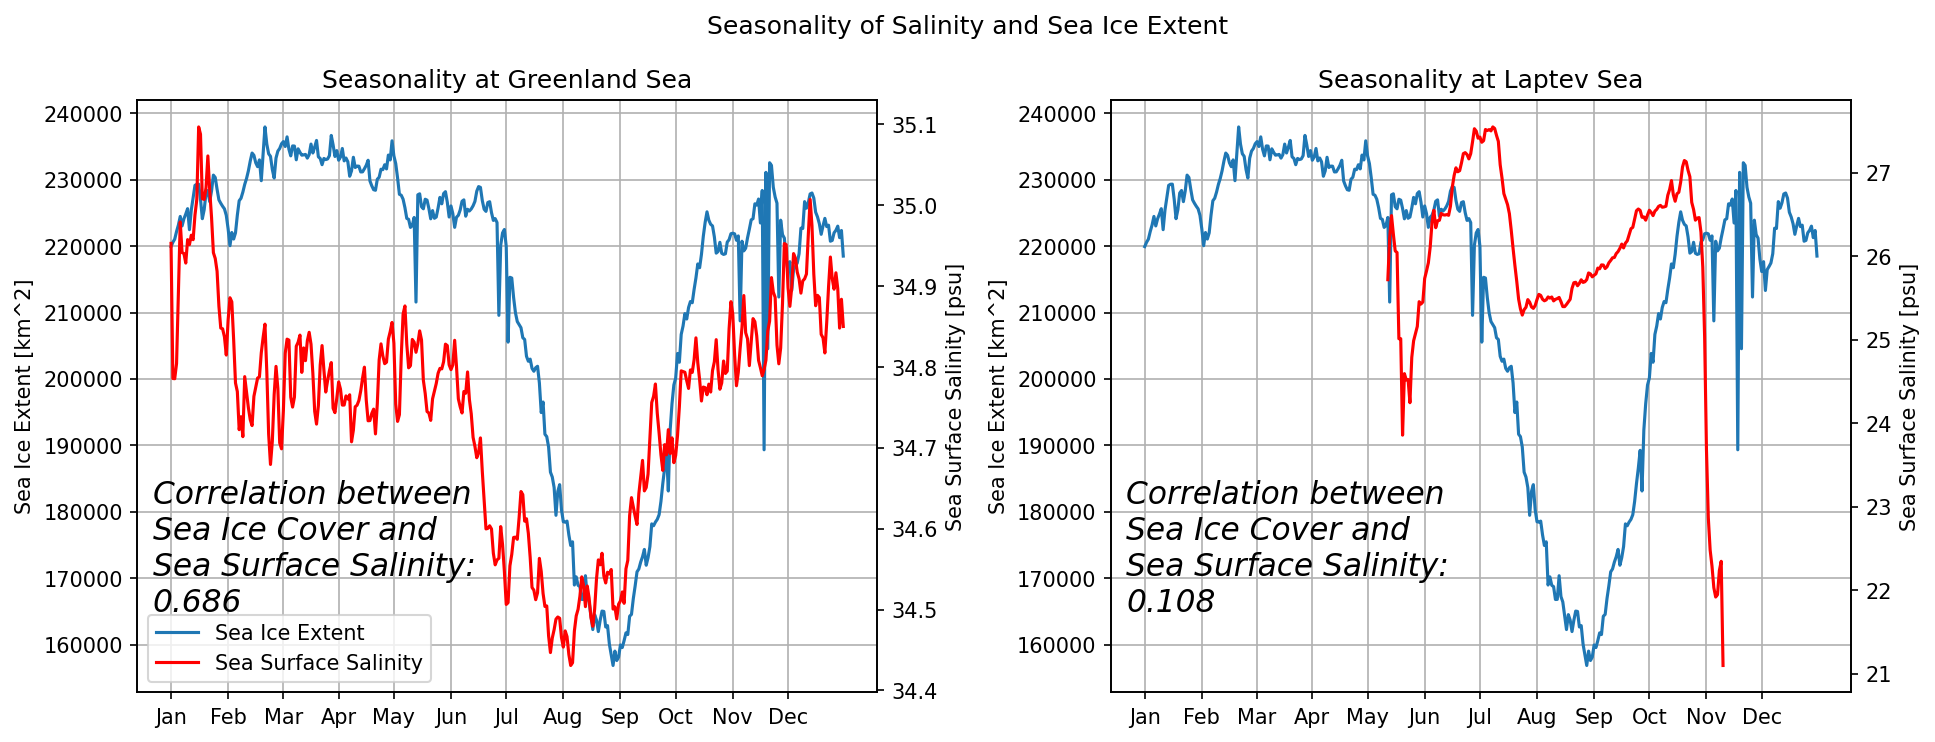

In [10]:
ice_path = 'AMSR2_E_Daily sea ice extent_GL sea.nc'
ice_path2 = 'DailySeaiceextentSiberianSea.nc'
ice_ds = xr.open_dataset(ice_path)
ice_ds2 = xr.open_dataset(ice_path2)

MeanIceDaily = ice_ds['z'].groupby('time.dayofyear').mean('time').compute()
STDIceDaily = ice_ds['z'].groupby('time.dayofyear').std('time').compute()

MeanIceDaily2 = ice_ds['z'].groupby('time.dayofyear').mean('time').compute()
STDIceDaily2 = ice_ds['z'].groupby('time.dayofyear').std('time').compute()

x = np.arange(366)
fig, ax = plt.subplots(1,2, figsize=(13,5), dpi=150)

ax1 = ax[0].twinx()
ax2 = ax[1].twinx()

ln = ax[0].plot(x, MeanIceDaily, label='Sea Ice Extent')
ln2 = ax1.plot(x, MeanSat, 'r', label='Sea Surface Salinity')
ax[0].legend()

ax[1].plot(x, MeanIceDaily2)
ax2.plot(x, MeanSat2, 'r')

dic = { 0:'Jan', 31:'Feb', 61:'Mar', 91:'Apr', 121:'May', 152:'Jun', 182:'Jul', 213:'Aug', 244:'Sep', 274:'Oct', 305:'Nov', 335:'Dec'}
ticks = [0,31,61,91,121,152,182,213,244,274,305,335]
labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]

nans = np.where(np.isnan(MeanSat2)) #Gives a list of indexes, from this list I can see that MeanSat2 is not nan between index 131 and 315
corr = [np.corrcoef(MeanIceDaily, MeanSat)[0,1], np.corrcoef(MeanIceDaily2[132:314], MeanSat2[132:314])[0,1]]

for i in range(2):
    ax[i].set_xticks(ticks)
    ax[i].set_xticklabels(labels)
    ax[i].grid()
    ax[i].text(-10, 165000, f'Correlation between \nSea Ice Cover and \nSea Surface Salinity:\n{corr[i]:.3f}', style ='italic',
        fontsize = 15, color ="black")
    ax[i].set_ylabel('Sea Ice Extent [km^2]')
ax1.set_ylabel('Sea Surface Salinity [psu]')
ax2.set_ylabel('Sea Surface Salinity [psu]')

lns = ln + ln2
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=0)

fig.suptitle('Seasonality of Salinity and Sea Ice Extent')
ax[0].set_title('Seasonality at Greenland Sea')
ax[1].set_title('Seasonality at Laptev Sea')

plt.tight_layout()
plt.show()

#SeaIceCover
#When Sea Ice melts, it will become thinner in the beginning, but will still cover the ocean
#this means that while the sea ice extent does not get much smaller, it becomes thinner, so we have a freshwater input into the ocean, meaning that salinity should decrease

*Figure 5: Seasonality of sea ice extent (blue) and sea surface salinity (red) at Greenland Sea (left) and Laptev Sea (right).*

Figure 5 shows the seasonality of SSS (red graph) compared to the seasonality of sea SIE (blue graph) at the two regions. The seasonality of SSS is exactly the same as in figure 3, but this time the we have enlarged the two figures so that one can see the fluctuations at both locations better (note that the SSS y-axis in the two panels in figure 5 differ). This allows us to see the seasonality of SSS at the Greenland Sea region better, and here we clearly see that the SSS value drops from around ~35 psu in June to around 34.5 psu in August (this was not as apparent in figure 3). 

NOTE::: I THINK BOTH THE SEA ICE EXTENTS ARE FOR THE GREENLAND SEA, DOUBLECHECK

First, taking a look at the left panel in figure 5, we see that SSS and SIE are well correlated, especially after the month of May, where we see that both SSS and SIE decreases and increases approximately at the same time. However, there is also a shift in the minimum peak of the two variables, where the minimum SSS happens about a month earlier than minimum SIE. This is not so strange when one considers that the SIE in the figure is only how far the sea ice actually extends, not how thick it is. This means that the thickness of the sea ice can decay, giving a freshwater input into the ocean, thus lowering SSS, whereas the extent of the sea ice does not change. When the ocean water freezes into sea ice again, sometime in September, we know that the salt crystals will not be freezed with the ocean water, but rather, be released into the ocean surface, which is why we notice an increase in SSS with an increase in SIE. 

The left panel in figure 5 also shows that SSS decreases during the months of February to May, while the SIE increases in the same time period. This might be due to the average acting strangely because of the missing data due to the sea ice, as talked about previously, however, it can also be due to freshwater input from other sources. For example, there might be more precipitation during this time period, or some other driving factors which should be studied more. 

For the correlation between SSS and SIE in the right panel of figure 5, one should really only consider the months between July and November, for the same reasons as stated previously. By only looking at these months, we see that SSS decreases during July, as does the SIE, and has a minimum during August, while the SIE still has a minimum during September, and both increase after that. By looking at the axis of the figures, we see that the SSS varies much more during this season at the Laptev Sea region than at the Greenland Sea region. We can assume that this is because the Laptev Sea has an additional freshwater input, other than sea ice decay, which is river runoff, and maybe the seasonality of river runoff should also be added to the figures to investigate its effect.

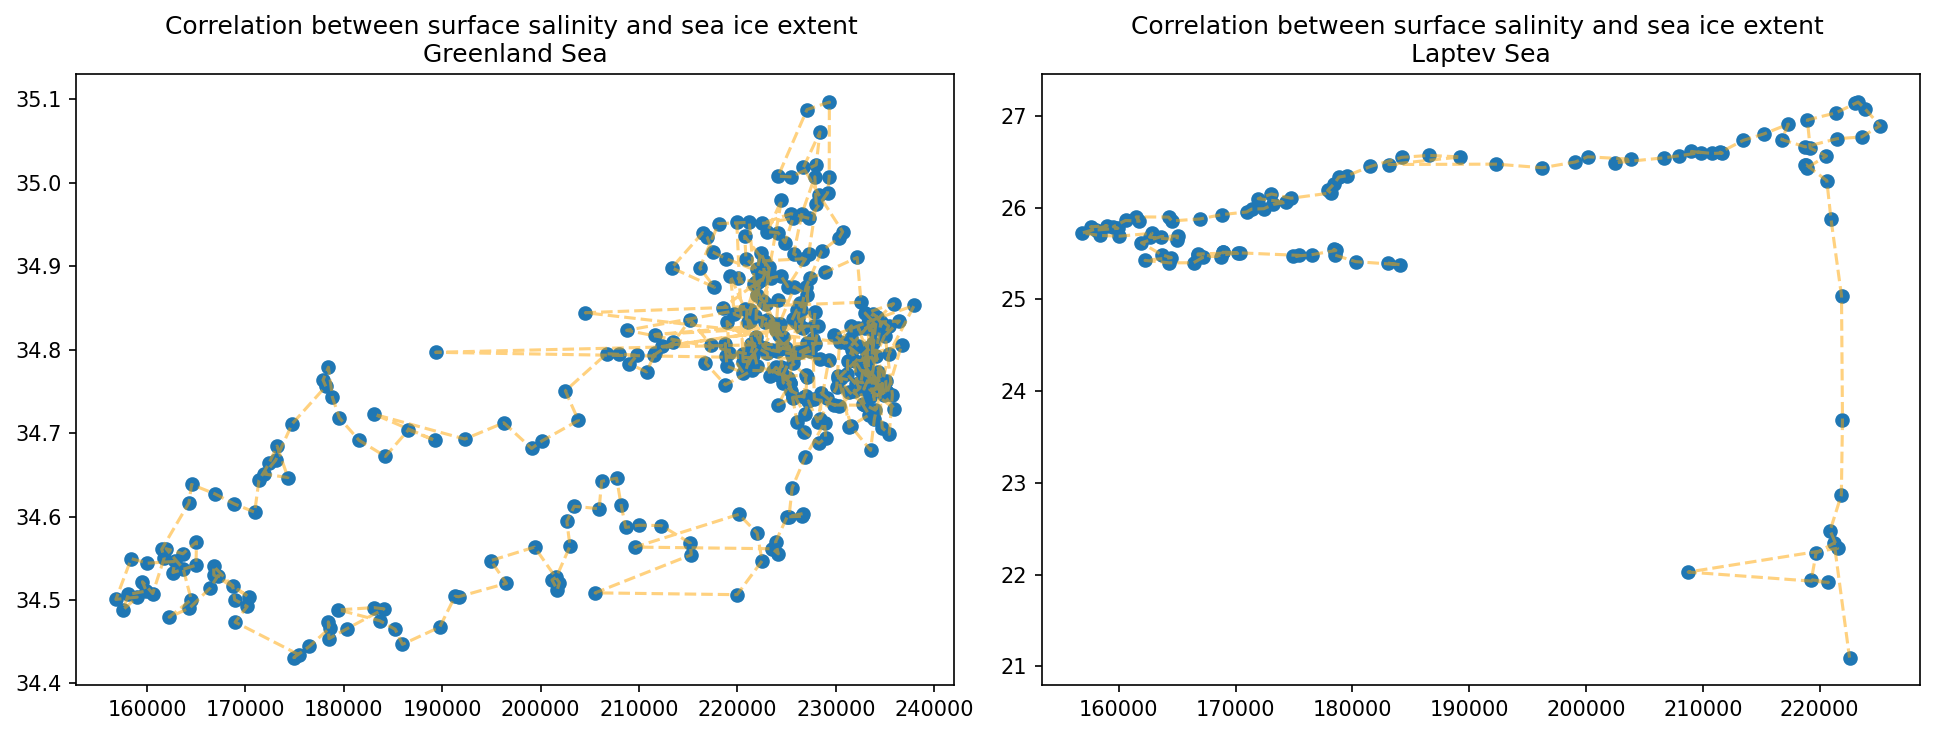

In [12]:
fig, ax = plt.subplots(1,2, figsize=(13,5), dpi=150)
ax[0].scatter(MeanIceDaily, MeanSat)
ax[1].scatter(MeanIceDaily2[7*30:11*30], MeanSat2[7*30:11*30])
ax[0].plot(MeanIceDaily, MeanSat, '--', color='orange', alpha=0.5)
ax[1].plot(MeanIceDaily2[7*30:11*30], MeanSat2[7*30:11*30], '--', color='orange', alpha=0.5)
ax[0].set_title('Correlation between surface salinity and sea ice extent \nGreenland Sea')
ax[1].set_title('Correlation between surface salinity and sea ice extent \nLaptev Sea')
plt.tight_layout()

*Figure 6: A figure showing the correlation between sea ice extent and sea surface salinity for satellite data by plotting them against one another. Greenland Sea on the left and Laptev Sea on the right.*

Figure 6 shows the correlation between the SIE and SSS for the Greenland Sea (left) and Laptev Sea (right). As can be noticed from the left panel, we have a correlation between the SIE and SSS, where both values get decrease and increase at the same time, as was apparent in figure 5 awsell. The correlation in the left panel of figure 6 also shows that the result of plotting these two against each other is circular (if one puts their willingness into it), which is what happens when the decrease and increase in the two values is shifted compared to one another.  

The right panel of figure 6 however, does not show any implications of there being a correlation. Here, only the data between June and November have been included for the Laptev Sea, because of the beforementioned reasons. We see that whenever SIE increases, it does not necessarely mean that SSS increases as well. So again, there must be some other factors here aswell, or just an error in the calculation of the average values for the region, as it is covered by ice for long periods of the year. 

## Validation of Model Data at the Surface

In [14]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(variable_id='so', source_id='UKESM1-0-LL', activity_id='CMIP', experiment_id='historical')
cat2 = col.search(variable_id='areacello', source_id='UKESM1-0-LL')
cat3 = col.search(source_id=['CNRM-ESM2-1'], 
                 experiment_id=['historical'], 
                 variable_id='so') 
cat4 = col.search(source_id=['CNRM-ESM2-1'], variable_id='areacello', activity_id='CMIP', experiment_id='historical', member_id='r1i1p1f2')

In [15]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
dset_dict2 = cat2.to_dataset_dict(zarr_kwargs={'use_cftime':True})
dset_dict3 = cat3.to_dataset_dict(zarr_kwargs={'use_cftime':True})
dset_dict4 = cat4.to_dataset_dict(zarr_kwargs={'use_cftime':True})
MDS_all = dset_dict[list(dset_dict.keys())[1]]
MDS2_all = dset_dict3[list(dset_dict3.keys())[0]]
ModelDataList2 = list(dset_dict2.keys())
ModelDataList4 = list(dset_dict4.keys())
MDS = MDS_all.isel(lev=0).so.mean('member_id', keep_attrs=True)
MDS2 = MDS2_all.isel(lev=0).so.mean('member_id', keep_attrs=True)
areacello = dset_dict2[ModelDataList2[0]].squeeze()
areacello2 = dset_dict4[ModelDataList4[0]].squeeze()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [16]:
MReg = MDS.sel(time = slice('1850','2010'))
MReg = f.slice_data(MReg, min_lat = 70, max_lat = 85, min_lon = -10, max_lon = 10)
MReg2 = MDS.sel(time = slice('1850','2010'))
MReg2 = f.slice_data(MReg2, min_lat = 70, max_lat = 80, min_lon = 100, max_lon = 160)


MReg3 = MDS2.sel(time = slice('1850', '2010'))
MReg3 = MReg3.where(
            (MReg3['lon'] > -10)
            & (MReg3['lon'] < 10)
            & (MReg3['lat'] > 70)
            & (MReg3['lat'] < 85),
            drop=True)
MReg4 = MDS2.sel(time = slice('1850', '2010'))
MReg4 = MReg4.where(
            (MReg4['lon'] > 100)
            & (MReg4['lon'] < 160)
            & (MReg4['lat'] > 70)
            & (MReg4['lat'] < 80),
            drop=True)

In [17]:
#Creating areacello DataArrays for the two regions, for the two models
ac=areacello.where(
    (areacello['longitude'] > -10)
    & (areacello['longitude'] < 10)
    & (areacello['latitude'] > 70)
    & (areacello['latitude'] < 85),
    drop=True
    )
ac2=areacello.where(
    (areacello['longitude'] > 100)
    & (areacello['longitude'] < 160)
    & (areacello['latitude'] > 70)
    & (areacello['latitude'] < 80),
    drop=True
    )
ac3=areacello2.where(
    (areacello2['lon'] > -10)
    & (areacello2['lon'] < 10)
    & (areacello2['lat'] > 70)
    & (areacello2['lat'] < 85),
    drop=True
    )
ac4=areacello2.where(
    (areacello2['lon'] > 100)
    & (areacello2['lon'] < 160)
    & (areacello2['lat'] > 70)
    & (areacello2['lat'] < 80),
    drop=True
    )

In [18]:
if not os.path.exists('MReg.nc'):
    with ProgressBar():
        MReg = f.WeightedMean(MReg, ac)
        MReg.to_netcdf('MReg.nc')
else:
    MReg = xr.open_dataset('MReg.nc')
    MReg = MReg['__xarray_dataarray_variable__'].rename('so')

In [19]:
if not os.path.exists('MReg2.nc'):
    with ProgressBar():
        MReg2 = f.WeightedMean(MReg2, ac2)
        MReg2.to_netcdf('MReg2.nc')
else:
    MReg2 = xr.open_dataset('MReg2.nc')
    MReg2 = MReg2['__xarray_dataarray_variable__'].rename('so')

In [20]:
if not os.path.exists('MReg3.nc'):
    with ProgressBar():
        MReg3 = f.WeightedMean(MReg3, ac3)
        MReg3.to_netcdf('MReg3.nc')
else:
    MReg3 = xr.open_dataset('MReg3.nc')
    MReg3 = MReg3['__xarray_dataarray_variable__'].rename('so')

In [21]:
if not os.path.exists('MReg4.nc'):
    with ProgressBar():
        MReg4 = f.WeightedMean(MReg4, ac4)
        MReg4.to_netcdf('MReg4.nc')
else:
    MReg4 = xr.open_dataset('MReg4.nc')
    MReg4 = MReg4['__xarray_dataarray_variable__'].rename('so')

In [22]:
MonthlyMean = MReg.groupby('time.month').mean('time')
MonthlyMean2 = MReg2.groupby('time.month').mean('time')
MonthlyMean3 = MReg3.groupby('time.month').mean('time')
MonthlyMean4 = MReg4.groupby('time.month').mean('time')
SatMean = xr.open_dataset('SSSGL.nc')
SatMean2 = xr.open_dataset('SSSLS.nc')

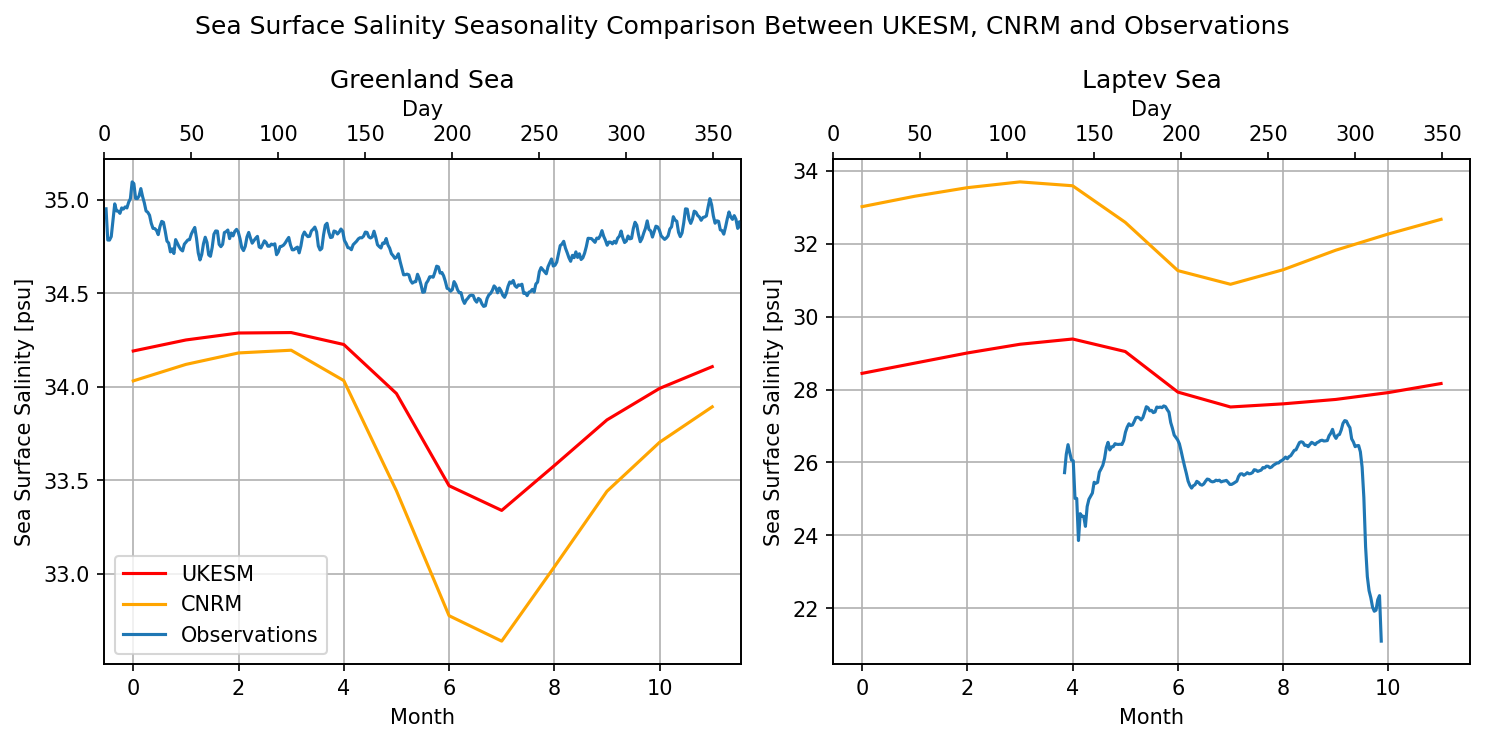

In [23]:
fig, ax = plt.subplots(1,2, figsize=(10,5), dpi=150)
x = np.arange(12)
#y = np.arange(len(SatMean))

ln = ax[0].plot(x, MonthlyMean, color='red', label='UKESM')
ln2 = ax[0].plot(x, MonthlyMean3, color='orange', label='CNRM')

ax[1].plot(x, MonthlyMean2, color='red', label='UKESM')
ax[1].plot(x, MonthlyMean4, color='orange', label='CNRM')

ax1 = ax[0].twiny()
ax2 = ax[1].twiny()

ln3 = ax1.plot(SatMean.dayofyear, SatMean.sss, label='Observations')
ax2.plot(SatMean2.dayofyear, SatMean2.sss)
ax1.set_xlabel('Day')
ax2.set_xlabel('Day')
ax1.set_xlim(0,366)
ax2.set_xlim(0,366)

for i in range(2):
    ax[i].set_xlabel('Month')
    ax[i].set_ylabel('Sea Surface Salinity [psu]')
    ax[i].grid()

lns = ln + ln2 + ln3
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc='lower left')
plt.suptitle('Sea Surface Salinity Seasonality Comparison Between UKESM, CNRM and Observations')
ax[0].set_title('Greenland Sea')
ax[1].set_title('Laptev Sea')

plt.tight_layout()

*Figure 7: Sesonality of sea surface salinity comparison between UKESM (red), CNRM (orange) and satellite observations (blue). Greenland Sea to the left and Laptev Sea to the right.*

Figure 7 shows the seasonal variation of SSS from satellite observations (blue), and multimember averages for the two selected earth system models, UKESM (red) and CNRM (orange). The left panel shows the seasonal SSS at the Greenland Sea, while the right panel shows the seasonal SSS at the Laptev Sea. Here, the SSS for the two models has been calculated by taking the average over the model time 1850-2010, whereas the satellite observations are still only availbale for the years 2009-2019. So there are more years included in the modelled SSS seasonality, and the satellite observations also cover later years. Therefore, comparing these outputs is not completely fair, however, the averages over the years should still give some indication of how well the models perform. 

By first looking at the left panel in figure 7, we see that the models underestimate SSS by around 1 psu in January, with CNRM underestimating slightly more than UKESM. As we approach the months of February-April, this underestimation gets smaller, however, when we move to the months of June-September, where we know that SIE decays, giving a freshwater input into the ocean surface, we see that this difference between the model outputs and the observed values grows. At SSS minimum, which, for the models happens around July, CNRM underestimates the SSS by around 2 psu, while UKESM underestimates by around 1 psu. However, the model outputs seem to estimate the seasonality of SSS approximately right, as even though they are underestimating the actual values, the models predict that SSS will decrease and increase approximately at the same months as the observations. 

Now taking a look at the right panel in figure 7, we see that the models actually overestimate SSS in the Laptev Sea, as opposed to the Greenland Sea. The UKESM is overestimating SSS by between 0.5-2 psu, while CNRM, which is again worse than UKESM at predicting the SSS, is overestimating by around 4 psu. However, the models do capture the seasonality of SSS, as they did in the Greenland Sea, but overestimating the values. 

When comparing model outputs to observations, we have to remember that the model averages are calculated for the entire Greenaland Sea or Laptev Sea regions, as the models include salinity at the ocean surface even though there is ice above. Whereas satellite observations only provide data for the regions where sea ice is absent. This will affect the comparison of the averages, as we the model outputs are averaged over a constant region for the whole season, while observations are averaged over a region which changes throughout the season. We have already talked about how the seasonal average of the Laptev Sea might be somewhat wrong due to sea ice, and in reality, the average seasonality produced by models and satellite observations at Laptev Sea might have been more similar if we had observations for the whole region throughout the whole year.

Meanwhile, one has to also consider that there is a freshwater input from rivers in the Laptev Sea, which should give this region a much lower SSS than at the Greenland Sea region. We see from figure 7 that the SSS values predicted by CNRM does not differ by a large amount, which tells us that the river runoff parametrization in CNRM at the Laptev Sea region might not be sufficient. 

## Validation of the Vertical Structure of Model Data

In [24]:
_id = '3901591'
argo_path = f's3://escience2022/Ada/ARGO/coriolis/{_id}/{_id}_prof.nc'
Argo = xr.open_dataset(s3.open(argo_path))

In [25]:
UKESM = MDS_all.so.mean('member_id', keep_attrs=True)
CNRM = MDS2_all.so.mean('member_id', keep_attrs=True)

In [26]:
UKESM = UKESM.sel(time=slice('2000', '2010'))
CNRM = CNRM.sel(time=slice('2000', '2010'))

In [27]:
UKESM = UKESM.where(
    (UKESM['longitude'] < 0)
    & (UKESM['longitude'] > -10)
    & (UKESM['latitude'] < 75)
    & (UKESM['latitude'] > 72),
    drop=True)
CNRM = CNRM.where(
    (CNRM['lon'] < 0)
    & (CNRM['lon'] > -10)
    & (CNRM['lat'] < 75)
    & (CNRM['lat'] > 72),
    drop=True)
MeanUKESM = UKESM.isel(lev=slice(0,60)).mean(dim=['i', 'j', 'time']).compute()
MeanCNRM = CNRM.isel(lev=slice(0,60)).mean(dim=['x', 'y', 'time']).compute()

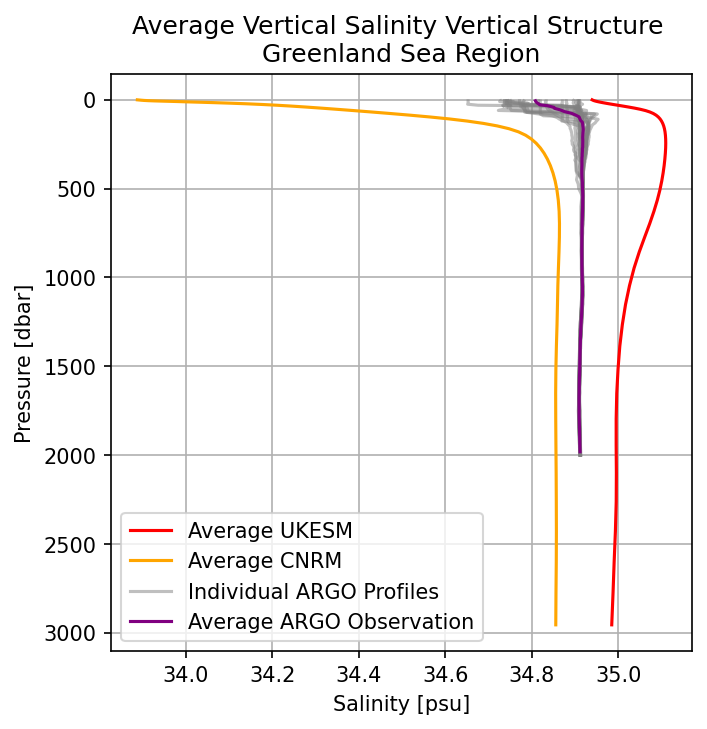

In [28]:
fig, ax = plt.subplots(figsize=(5,5), dpi=150)
plt.plot(MeanUKESM, MeanUKESM.lev, color='red', label='Average UKESM')
plt.plot(MeanCNRM, MeanCNRM.lev, color='orange', label='Average CNRM')
ax.invert_yaxis()
plt.plot(Argo['PSAL_ADJUSTED'][0], Argo['PRES_ADJUSTED'][0], color='gray', alpha=0.5, label='Individual ARGO Profiles')
for i in range(1, len(Argo['PSAL_ADJUSTED'])):
    plt.plot(Argo['PSAL_ADJUSTED'][i], Argo['PRES_ADJUSTED'][i], color='gray', alpha=0.5)

ArgoMean = Argo['PSAL_ADJUSTED'].mean(dim='N_PROF', keep_attrs=True)
PresMean = Argo['PRES_ADJUSTED'].mean(dim='N_PROF', keep_attrs=True)
plt.plot(ArgoMean, PresMean, color='purple', label='Average ARGO Observation')
plt.title('Average Vertical Salinity Vertical Structure \nGreenland Sea Region')
plt.ylabel('Pressure [dbar]')
plt.xlabel('Salinity [psu]')
plt.legend()
plt.grid()

*Figure 8: The vertical structure of ocean salinity at the Greenland Sea region. UKESM (red), CNRM (orange), individual observational profiles (gray) and average of the observational profiles (purple).*

Figure 8 shows the average vertical structure of salinity for the Greenland Sea region. The red line is the average for UKESM, orange is CNRM, purple is ARGO observations in the region and the gray lines are the individual ARGO profiles. The average from UKESM and CNRM is calculated from model outputs between 2000 and 2010, while the ARGO profiles were taken between 2016 and 2018. 

First of, we notice that the argo floats only go down to around 2000 dbar, while the modelled salinity goes all the way down to 3000 dbar. This shows the importance of model data: we have no observations below 2000 dbar, and if the model is good, it can supplement the missing observations. 

We also notice that CNRM underestimates the salinity at the surface by around 1 psu, however, CNRM quickly converges towards observational data between 0-250 dbar. The opposite happens for UKESM, which predicts salinity levels at the surface which are very close to actual observation, only overestimating by less than 0.5 psu, but then UKESM deviates away from the observations. It is actually quite interesting that UKESM overestimates the salinity levels at the surface here, as figure 7 showed that UKESM actually underestimates SSS. This might be due to the region that has been chosen for this particular case, or the fact that here we are averaging over 10 years, while the results in figure 7 were averaged over 150 years. 

Nevertheless, CNRM converges quickly towards observational data at depth, while UKESM start off by deviating slightly, but after a couple houndred dbar the model starts converging towards observational data again. It is quite apparent that both models do a good job at predicting the salinity at depth, only missing observations by a small margin. Figures 7 and 8 also shows that even though CNRM is worse at predicting salinity at the surface, it is better than UKESM when it comes to salinity at depth for this particular region. 

Observations also show that salinity is lowest at the ocean surface, and then increases with depth for the first ~100 dbar, after which the salinity is almost constant. This is consistent with the theory that saline water is heavier than sweeter water, and will therefore sink under sweeter water. The individual ARGO profiles also show that there is some variation between the salinity profiles at the surface, but they measure approximately the same values at depth. At the same time, we know that most freshwater input into the ocean happens at the surface, especially in this region, by either precipitation or sea ice decay (there are no rivers here). Therefore, it makes sense that the surface exhibits more variation in salinity than deeper waters. 

In [29]:
month1 = SatRegion1['time.month']
year1 = SatRegion1['time.year']
month2 = SatRegion2['time.month']
year2 = SatRegion2['time.year']

TimeSeriesMean1 = SatRegion1['sss'].mean(dim=['x', 'y']).compute()
TimeSeriesStd1 = SatRegion1['sss'].std(dim=['x', 'y']).compute()
TimeSeriesMean2 = SatRegion2['sss'].mean(dim=['x', 'y']).compute()
TimeSeriesStd2 = SatRegion2['sss'].std(dim=['x', 'y']).compute()

/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [ ]:
fig, ax = plt.subplots(3,2, figsize=(15,10), dpi=150)

ax[0,0].plot(TimeSeriesMean1.time, TimeSeriesMean1, lw=3, color='cadetblue', label='Average salinity')
ax[0,0].fill_between(TimeSeriesMean1.time, TimeSeriesMean1-TimeSeriesStd1, TimeSeriesMean1+TimeSeriesStd1, color='seagreen', alpha=0.25, label='Standard deviation')

x = np.arange(len(TimeSeriesMean1.time))
res = stats.linregress(x, TimeSeriesMean1)
ax[0,0].plot(TimeSeriesMean1.time, res.intercept + res.slope*x, color='red', lw=5, label='Trend')
ax[0,0].legend()

ax[0,1].plot(TimeSeriesMean2.time, TimeSeriesMean2)
ax[0,1].fill_between(TimeSeriesMean2.time, TimeSeriesMean2-TimeSeriesStd2, TimeSeriesMean2+TimeSeriesStd2, color='seagreen', alpha=0.25)

x = np.arange(len(TimeSeriesMean2.time))
res = stats.linregress(x, TimeSeriesMean2)
ax[0,1].plot(TimeSeriesMean2.time, res.intercept + res.slope*x, color='red', lw=5)

ax[1,0].plot(MReg.time, MReg, color='cadetblue')
ax[1,1].plot(MReg2.time, MReg2, color='cadetblue')

x = np.arange(len(MReg.time))
res = stats.linregress(x, MReg)
ax[1,0].plot(MReg.time, res.intercept + res.slope*x, color='red', lw=5)

x = np.arange(len(MReg2.time))
res = stats.linregress(x, MReg2)
ax[1,1].plot(MReg2.time, res.intercept + res.slope*x, color='red', lw=5)

ax[2,0].plot(MReg3.time, MReg3, color='cadetblue')
ax[2,1].plot(MReg4.time, MReg4, color='cadetblue')

x = np.arange(len(MReg3.time))
res = stats.linregress(x, MReg3)
ax[2,0].plot(MReg3.time, res.intercept + res.slope*x, color='red', lw=5)

x = np.arange(len(MReg4.time))
res = stats.linregress(x, MReg4)
ax[2,1].plot(MReg4.time, res.intercept + res.slope*x, color='red', lw=5)

plt.suptitle('Timeseries of Sea Surface Salinity Evolution')
ax[0,0].set_title('Satellite Observations Greenland Sea')
ax[1,0].set_title('UKESM Greenland Sea')
ax[2,0].set_title('CNRM Greenland Sea')
ax[0,1].set_title('Satellite Observations Laptev Sea')
ax[1,1].set_title('UKESM Laptev Sea')
ax[2,1].set_title('CNRM Laptev Sea')

for i in range(3):
    for j in range(2):
        ax[i,j].set_ylabel('Salinity [psu]')

*Figure 9: Time series of sea surface salinity at the two regions, Greenland Sea and Laptev Sea. Top row shows observational data, middle row is UKESM predictions and bottom row is CNRM predictions.*

Figure 9 shows the time evolution of SSS at the two regions, Greenland Sea and Laptev Sea, observed by satellite and predicted by the two models, UKESM and CNRM. The figures also include a trend, which is trying to show if the salinity increases or decreases over time. As we can see, there is no trend for the satellite observations at Laptev Sea, as the values from this region are disjointed from one another. On top of that, we only have 10 years of observational data, which is strictly speaking not enough data to draw any conclusions on how SSS will evolve in the future. 

Meanwhile, we have model data from both UKESM and CNRM which start in 1850, which is more than enough to say something about how SSS will evolve in the future. Looking at the modelled trends, all except for UKESM at Greenland Sea predicts that SSS will decrease in the future. CRNM however, predicts that this decrease will be very little, and maybe not significant. Nevertheless, freshening of the ocean surface has been predicted as temperatures increase, leading to more snow/ice melt, which will result in a more stable stratification in the ocean, hindering the vertical circulation. 

UKESM predicts a rather large decrease in SSS for the Laptev Sea, and the decrease seems to be somewhat constant since the late 1800s. There might be some realistic explanation for this, however, in general, ice melting has increased in the last 30 years or so, and definitely not since the late 1800s. Because this is the Laptev Sea region, this drastic decrease over time might be a result of how UKESM parameterizes the river runoffs, or it might be a result of variable drift in the model. CNRM does not predict such a draastic decreasefor the region, however, we also see that CNRM predicts much larger salinity values. 

# Conclusions

In this project, we have investigated the seasonality of sea surface salinity in two Arctic regions, the Greenland Sea and the Laptev Sea. We quickly notice that there are few ocean observations in the Arctic, due to the harsh Arctic environment. Models are therefore crucial for filling out the gaps in observations, and so we have compared two models, the UKESM and CNRM, to observational data for these two regions. 

We see evidence of seasonality for sea surface salinity being heavily influenced by sea ice extent, especially in the Greenland Sea region. In this region, we see that whenever sea ice extent decays, this will lead to a freshwater input into the ocean surface, also decreasing surface salinity concentration. On the other hand, the Laptev Sea region shows some evidence of being influenced by the sea ice melt, but there are other factors at play here as well, for example rivers. Additionally, the fact that there is less observational data in the Laptev Sea region due to the area being almost completely covered by sea ice during long periods of the year, results in large uncertainties. 

In general, the models underestimate the sea surface salinity at the Greenland Sea region, and overestimates at the Laptev Sea region, with UKESM doing a better job at predicting the observed values in both regions. Meanwhile, even though CNRM might be missing something at the ocean surface, the model yields more accurate results in comparison to observation at depth than the UKESM model for the Greenland Sea region. Both models actually show only small deviations from the observed salinity values as the depth increases.

# Acknowledgements
I would like to thank the following people:

Antoine Haddon for his help, guidance and good discussions we had about this topic during the working process.

Michael Schulz and Paul Zieger for hosting the eScience 2022 course.

Stian Leer-Salvesen Dammann for granting me fun discussions and giving me ideas on how to proceed, as well as giving some tips for the code.

Jessica Burger for providing the sea ice extent data which has been used in this report.

# References

* [Argo, 2022] Argo float data and metadata from Global Data Assembly Centre (Argo GDAC). SEANOE. https://doi.org/10.17882/42182
* [noa, 2021a] (2021a). Greenland Sea. Section: WorldAtlas Originals.
* [noa, 2021b] (2021b). Laptev Sea. Section: WorldAtlas Originals.
* [Manabe and Stouffer, 1995] Manabe, S. and Stouffer, R. J. (1995). Simulation
    of abrupt climate change induced by freshwater input to the North Atlantic
    Ocean. Nature, 378(6553):197–212. Number: 6553 Publisher: Nature Pub-
    lishing Group.
* [Mart ́ınez et al., 2020] Mart ́ınez, J., Gabarr ́o, C., and Turiel, A. (2020). Arctic
    Sea Surface Salinity L2 orbits and L3 maps (V.3.1) [Dataset]. Accepted:
    2020-09-16T09:11:52Z Publisher: CSIC - Instituto de Ciencias del Mar (ICM)
    Type: dataset.
* [Mart ́ınez et al., 2022] Mart ́ınez, J., Gabarr ́o, C., Turiel, A., Gonz ́alez-Gambau,
    V., Umbert, M., Hoareau, N., Gonz ́alez-Haro, C., Olmedo, E., Arias, M.,
    Catany, R., Bertino, L., Raj, R. P., Xie, J., Sabia, R., and Fern ́andez, D.
    (2022). Improved BEC SMOS Arctic Sea Surface Salinity product v3.1. Earth
    System Science Data, 14(1):307–323. Publisher: Copernicus GmbH.
* [Spreen et al., 2008] Spreen, G., Kaleschke, L., and Heygster, G.
    (2008). Sea ice remote sensing using AMSR-E 89-GHz chan-
    nels. Journal of Geophysical Research: Oceans, 113(C2). eprint:
    https://onlinelibrary.wiley.com/doi/pdf/10.1029/2005JC003384.
